# Classificação de dígitos (MNIST)

Por João Hirasawa

O notebook já contém todos os outputs do processo realizado. Mas, caso queira rodá-lo mesmo assim, há uma pequena modificação a ser feita no último capítulo: o caminho das imagens deve ser adaptado para o seu drive.

# 1. Bibliotecas

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import expon
from joblib import dump, load

# Carregamento dos dados
from sklearn.datasets import fetch_openml
from PIL import Image

# Pré-processamento dos dados
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.interpolation import shift

# Modelos e seleção de hiperparâmetros
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

# Avaliação
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix

# 2. Carregamento dos dados

In [ ]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [ ]:
def plot_digit(X, y, n):
  plt.imshow(np.reshape(X[n], (28,28)), cmap='binary')
  plt.title(f'Linha: {n}. Número: {y[n]}.') # fontdict={'color': '#ffffff'}
  plt.axis('off')

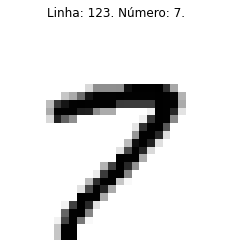

In [ ]:
plot_digit(X, y, 123)

In [ ]:
y = y.astype(np.uint8)

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 3. Regressão Logística

## 3.1 Treinamento

Criação do modelo, ajustado com alguns hiperparâmetros.

In [ ]:
logit_clf = LogisticRegression(C=0.1, tol = 0.01, solver='sag', multi_class='multinomial', random_state=0)
logit_clf.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='sag', tol=0.01, verbose=0,
                   warm_start=False)

In [ ]:
print('Acurácia:', logit_clf.score(X_test, y_test))

Acurácia: 0.9257


A regressão logística nos fornece as probabilidades para cada classe. Podemos acessá-las por meio do método decision_function().

In [ ]:
logit_clf.decision_function(X_test)[0]

array([ -0.62287614, -17.80283262,   0.14856905,   8.43198631,
        -2.91036529,   1.85023012, -12.91659493,  14.24018792,
         3.37654876,   6.2051468 ])

Vamos pegar um exemplo e analisar o que o modelo nos diz.

In [ ]:
logit_clf.predict(X_test[0].reshape(1,-1))

array([7], dtype=uint8)

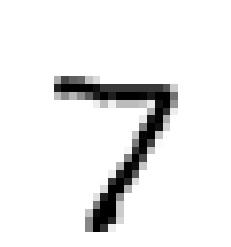

In [ ]:
plot_digit(X_test, y_test, 0)

## 3.2 Fine-tuning

Usando grid search. CUIDADO: demora muito!

In [ ]:
logit_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'tol': [0.1, 0.01, 0.001, 0.0001],
    'penalty': ['l1', 'l2'],
    'solver': ['sag'],
    'multi_class': ['multinomial'],
}

logit_gs = GridSearchCV(LogisticRegression(), logit_params, n_jobs=-1, verbose=1)

In [ ]:
# Descomente para usar
# logit_gs.fit(X_train_transformed, y_train)

Usando randomized search. O uso de uma busca aleatória dentro de distribuições de variáveis aleatórias acelera imensamente o processo. Pode ser customizado o número de combinações feitas, folds, iterações, etc.

In [ ]:
logit_distribs = {
    'C': expon(scale=100),
    'tol': expon(scale=0.1),
    'penalty': ['l1', 'l2'],
    'solver': ['sag'],
    'multi_class': ['multinomial'],
}

logit_rs = RandomizedSearchCV(LogisticRegression(), logit_distribs, n_jobs=-1, verbose=10)

In [ ]:
logit_rs.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.1min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fda19d72e10>,
                                        'multi_class': ['multinomial'],
                                        'penalty': ['l1', 'l2'],
                          

Após a busca, o RandomizedSearchCV (ou GridSearchCV) treina o modelo com os dados e utilizando os hiperparâmetros mais "adequados" que encontrou.

In [ ]:
logit_rs.best_params_

{'C': 42.444863004857034,
 'multi_class': 'multinomial',
 'penalty': 'l2',
 'solver': 'sag',
 'tol': 0.05921476364715383}

Note que houve uma pequena piora no desempenho! Isso pode acontecer por conta de uma tunagem não-ótima, limitações do modelo, etc..

In [ ]:
logit_rs.score(X_test, y_test)

0.9238

## 3.3 Avaliação

Métricas do modelo sem otimização dos hiperparâmetros.

A matriz de confusão nos informa as previsões feitas para cada exemplo, comparando a classe verdadeira do exemplo com a classe predita.

In [ ]:
y_pred_logit = logit_clf.predict(X_test)
confusion_matrix(y_test, y_pred_logit)

array([[ 959,    0,    0,    3,    1,    5,    6,    3,    2,    1],
       [   0, 1117,    5,    2,    0,    1,    3,    1,    6,    0],
       [   5,   10,  925,   17,    9,    3,   11,   11,   39,    2],
       [   4,    0,   17,  927,    1,   22,    2,    9,   21,    7],
       [   1,    2,    5,    3,  917,    0,    9,    6,   10,   29],
       [  12,    3,    2,   37,   10,  767,   14,    7,   35,    5],
       [   9,    3,    7,    2,    6,   17,  911,    2,    1,    0],
       [   2,    5,   23,    6,    5,    1,    0,  948,    4,   34],
       [   8,   13,    5,   24,    6,   24,    9,   10,  863,   12],
       [   9,    7,    1,    9,   24,    6,    0,   21,    9,  923]])

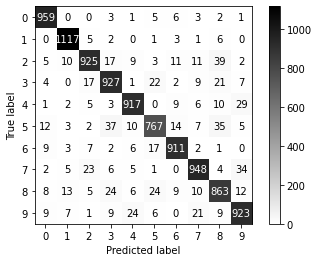

In [ ]:
plot_confusion_matrix(logit_clf, X_test, y_test, values_format='d', cmap='binary')

Precisão e recall são medidas que podem ter mais informação do que a acurácia (procure a teoria). F1 é a média harmônica da precissão e do recall.

In [ ]:
print("Precisão (macro):", precision_score(y_test, y_pred_logit, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_logit, average='macro'))
print("F1 (macro):", f1_score(y_test, y_pred_logit, average='macro'))
print("\nPrecisão (micro):", precision_score(y_test, y_pred_logit, average='micro'))
print("Recall (micro):", recall_score(y_test, y_pred_logit, average='micro'))
print("F1 (micro):", f1_score(y_test, y_pred_logit, average='micro'))

Precisão (macro): 0.9249161240503874
Recall (macro): 0.9244448536843277
F1 (macro): 0.9245284536695328

Precisão (micro): 0.9257
Recall (micro): 0.9257
F1 (micro): 0.9257


Ainda há outras medidas, como curva ROC e a área abaixo da curva, dentre outras..

Métricas do modelo COM o RandomizedSearch.

In [ ]:
y_pred_logit_rs = logit_rs.predict(X_test)

In [ ]:
confusion_matrix(y_test, y_pred_logit_rs)

array([[ 964,    0,    1,    3,    0,    3,    4,    3,    1,    1],
       [   0, 1115,    4,    2,    0,    1,    3,    2,    8,    0],
       [   4,   10,  932,   12,    7,    3,   11,    9,   40,    4],
       [   3,    1,   18,  922,    1,   18,    3,   10,   23,   11],
       [   1,    1,    8,    3,  910,    0,    6,    4,   11,   38],
       [  10,    3,    5,   42,   11,  756,   11,    8,   38,    8],
       [   9,    3,   11,    1,    9,   17,  904,    2,    2,    0],
       [   1,    6,   24,    4,    5,    1,    0,  948,    3,   36],
       [   7,   11,    7,   20,    9,   32,    9,    9,  857,   13],
       [   9,    8,    1,    9,   21,    5,    0,   19,    7,  930]])

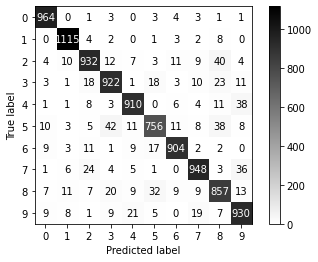

In [ ]:
plot_confusion_matrix(logit_rs, X_test, y_test, values_format='d', cmap='binary')

In [ ]:
print("Precisão (macro):", precision_score(y_test, y_pred_logit_rs, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_logit_rs, average='macro'))
print("F1 (macro):", f1_score(y_test, y_pred_logit_rs, average='macro'))
print("\nPrecisão (micro):", precision_score(y_test, y_pred_logit_rs, average='micro'))
print("Recall (micro):", recall_score(y_test, y_pred_logit_rs, average='micro'))
print("F1 (micro):", f1_score(y_test, y_pred_logit_rs, average='micro'))

Precisão (macro): 0.9230849132849448
Recall (macro): 0.9223631273990417
F1 (macro): 0.9225564266367892

Precisão (micro): 0.9238
Recall (micro): 0.9238
F1 (micro): 0.9238


# 4. Árvore de Decisão

## 4.1 Treinamento

In [ ]:
tree_clf = DecisionTreeClassifier(random_state=0)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
print('Acurácia: ', tree_clf.score(X_test, y_test))

Acurácia:  0.8781


Cross-validation é algo legal a ser usado para comparar modelos. Não irei utilizar neste notebook, apenas mostrando um jeito de se fazer.

In [ ]:
scores = cross_val_score(tree_clf, X_train, y_train, scoring='accuracy')
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard deviation:", scores.std())

Scores: [0.87225    0.85825    0.85925    0.86416667 0.87775   ]
Mean: 0.8663333333333334
Standard deviation: 0.007557189365836447


## 4.2 Avaliação

In [ ]:
y_pred_tree = tree_clf.predict(X_test)
confusion_matrix(y_test, y_pred_tree)

array([[ 915,    0,    4,    8,    5,   11,   14,    4,    8,   11],
       [   0, 1090,    8,   11,    1,    6,    8,    1,    9,    1],
       [  15,    7,  879,   33,   14,    9,   11,   24,   30,   10],
       [  11,    5,   29,  865,    7,   37,    4,    9,   23,   20],
       [   5,    2,    7,    5,  866,    8,   14,   11,   21,   43],
       [  13,    7,    3,   50,    6,  751,   23,    6,   21,   12],
       [  16,    3,   15,   10,   22,   20,  842,    2,   24,    4],
       [   2,   12,   26,   13,    6,    6,    4,  929,    9,   21],
       [  10,    7,   29,   41,   17,   27,   16,   10,  788,   29],
       [  14,    2,   11,   20,   41,    8,    9,   20,   28,  856]])

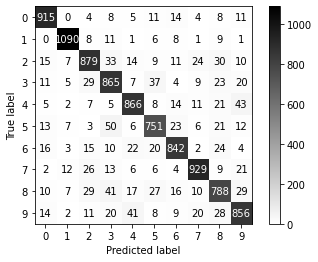

In [ ]:
plot_confusion_matrix(tree_clf, X_test, y_test, values_format='d', cmap='binary')

In [ ]:
print("Precisão (macro):", precision_score(y_test, y_pred_tree, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_tree, average='macro'))
print("F1 (macro):", f1_score(y_test, y_pred_tree, average='macro'))
print("\nPrecisão (micro):", precision_score(y_test, y_pred_tree, average='micro'))
print("Recall (micro):", recall_score(y_test, y_pred_tree, average='micro'))
print("F1 (micro):", f1_score(y_test, y_pred_tree, average='micro'))

Precisão (macro): 0.8768104980709447
Recall (macro): 0.8766018228319336
F1 (macro): 0.8766317499104777

Precisão (micro): 0.8781
Recall (micro): 0.8781
F1 (micro): 0.8781


# 5. Random Forest

## 5.1 Treinamento

In [ ]:
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
print('Acurácia: ', rf_clf.score(X_test, y_test))

Acurácia:  0.9705


In [ ]:
# Salvando o modelo
# dump(rf_clf, '/content/drive/MyDrive/rf_clf.joblib')

['/content/drive/MyDrive/rf_clf.joblib']

## 5.2 Avaliação

In [ ]:
y_pred_rf = rf_clf.predict(X_test)
confusion_matrix(y_test, y_pred_rf)

array([[ 969,    0,    0,    0,    0,    2,    5,    1,    3,    0],
       [   0, 1124,    2,    3,    0,    2,    2,    1,    1,    0],
       [   5,    0,  999,    7,    2,    0,    3,    9,    7,    0],
       [   1,    0,   10,  971,    0,   10,    0,    8,    8,    2],
       [   1,    0,    1,    0,  958,    0,    6,    0,    2,   14],
       [   3,    0,    0,   11,    0,  862,    8,    2,    4,    2],
       [   6,    3,    0,    0,    3,    4,  939,    0,    3,    0],
       [   1,    3,   20,    1,    0,    0,    0,  989,    3,   11],
       [   5,    0,    5,    6,    4,    9,    4,    4,  928,    9],
       [   8,    5,    1,    9,    8,    3,    1,    4,    4,  966]])

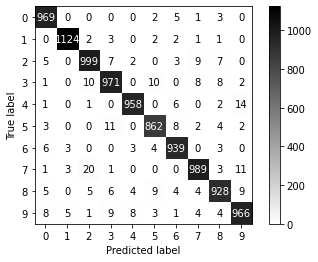

In [ ]:
plot_confusion_matrix(rf_clf, X_test, y_test, values_format='d', cmap='binary')

In [ ]:
print("Precisão (macro):", precision_score(y_test, y_pred_rf, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_rf, average='macro'))
print("F1 (macro):", f1_score(y_test, y_pred_rf, average='macro'))
print("\nPrecisão (micro):", precision_score(y_test, y_pred_rf, average='micro'))
print("Recall (micro):", recall_score(y_test, y_pred_rf, average='micro'))
print("F1 (micro):", f1_score(y_test, y_pred_rf, average='micro'))

Precisão (macro): 0.9702292282943962
Recall (macro): 0.9702805962559312
F1 (macro): 0.9702351062124602

Precisão (micro): 0.9705
Recall (micro): 0.9705
F1 (micro): 0.9705


# 6. Data augmentation

Código retirado de https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb

Criando uma função que pode fazer um "shift" nas imagens na direção informada.

In [ ]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

(-0.5, 27.5, 27.5, -0.5)

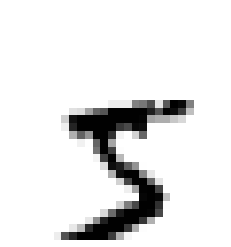

In [ ]:
# Exemplo deslocando 5 pixels para baixo.
plt.imshow(shift_image(X_train[0], 0, 5).reshape(28,28), cmap='binary')
plt.title(f'Linha: 0. Número: {y_train[0]}.', fontdict={'color': '#ffffff'})
plt.axis('off')

Realizando o augmentation.

In [ ]:
X_train_aug = [image for image in X_train]
y_train_aug = [label for label in y_train]

for dx, dy in ((2, 0), (-2, 0), (0, 2), (0, -2)):
    for image, label in zip(X_train, y_train):
        X_train_aug.append(shift_image(image, dx, dy))
        y_train_aug.append(label)

X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)

CUIDADO: rodar o código abaixo demora consideravelmente.

In [ ]:
# Descomente para rodar
# rf_aug_clf = RandomForestClassifier(n_jobs=-1, random_state=0)
# rf_aug_clf.fit(X_train_aug, y_train_aug)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
print('Acurácia: ', rf_aug_clf.score(X_test, y_test))

Acurácia:  0.9757


In [ ]:
y_pred_aug = rf_aug_clf.predict(X_test)
confusion_matrix(y_test, y_pred_aug)

array([[ 971,    0,    0,    0,    0,    1,    3,    1,    3,    1],
       [   0, 1123,    3,    2,    0,    1,    2,    0,    3,    1],
       [   4,    0, 1015,    1,    1,    0,    1,    5,    4,    1],
       [   0,    0,    6,  980,    0,    9,    0,    5,    8,    2],
       [   1,    0,    1,    0,  952,    0,    6,    0,    4,   18],
       [   3,    0,    0,   13,    3,  860,    4,    1,    7,    1],
       [   9,    2,    0,    0,    3,    1,  941,    0,    2,    0],
       [   1,    3,   16,    0,    1,    0,    0,  993,    3,   11],
       [   4,    0,    1,    0,    6,    3,    2,    1,  952,    5],
       [   9,    3,    0,    6,    6,    7,    1,    2,    5,  970]])

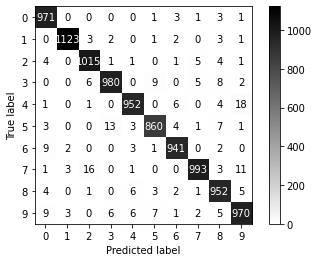

In [ ]:
plot_confusion_matrix(rf_aug_clf, X_test, y_test, values_format='d', cmap='binary')

In [ ]:
print("Precisão (macro):", precision_score(y_test, y_pred_aug, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_aug, average='macro'))
print("F1 (macro):", f1_score(y_test, y_pred_aug, average='macro'))
print("\nPrecisão (micro):", precision_score(y_test, y_pred_aug, average='micro'))
print("Recall (micro):", recall_score(y_test, y_pred_aug, average='micro'))
print("F1 (micro):", f1_score(y_test, y_pred_aug, average='micro'))

Precisão (macro): 0.9754970484308364
Recall (macro): 0.9754612068025541
F1 (macro): 0.9754404998760678

Precisão (micro): 0.9757
Recall (micro): 0.9757
F1 (micro): 0.9757


Salvando o modelo. Caso queira utilizar, os dois modelos de random forest estarão no [Drive](https://drive.google.com/drive/folders/1o6fKFfR1Jkw5RRyKI9_g-GYvQm6KLRWq?usp=sharing).

In [ ]:
# dump(rf_aug_clf, '/content/drive/MyDrive/rf_aug_clf.joblib')

['/content/drive/MyDrive/rf_aug_clf.joblib']

# 7. (Bônus) Meu próprio input!

In [ ]:
im_0 = Image.open('/content/0.bmp')
im_3 = Image.open('/content/3.bmp')
im_5 = Image.open('/content/5.bmp')
im_6 = Image.open('/content/6.bmp')

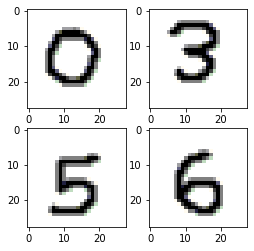

In [ ]:
fig=plt.figure(figsize=(4, 4))
fig.add_subplot(2, 2, 1)
plt.imshow(im_0)
fig.add_subplot(2, 2, 2)
plt.imshow(im_3)
fig.add_subplot(2, 2, 3)
plt.imshow(im_5)
fig.add_subplot(2, 2, 4)
plt.imshow(im_6)

In [ ]:
im_0 = np.invert(np.array(im_0)).reshape(1,-1)
im_3 = np.invert(np.array(im_3)).reshape(1,-1)
im_5 = np.invert(np.array(im_5)).reshape(1,-1)
im_6 = np.invert(np.array(im_6)).reshape(1,-1)

Usando o modelo sem augmentation.

In [ ]:
print('Real: 0. Predito:', rf_clf.predict(im_0)[0])
print('Real: 3. Predito:', rf_clf.predict(im_3)[0])
print('Real: 5. Predito:', rf_clf.predict(im_5)[0])
print('Real: 6. Predito:', rf_clf.predict(im_6)[0])

Real: 0. Predito: 9
Real: 3. Predito: 3
Real: 5. Predito: 5
Real: 6. Predito: 5


Usando o modelo COM augmentation. :OOOO

In [ ]:
print('Real: 0. Predito:', rf_aug_clf.predict(im_0)[0])
print('Real: 3. Predito:', rf_aug_clf.predict(im_3)[0])
print('Real: 5. Predito:', rf_aug_clf.predict(im_5)[0])
print('Real: 6. Predito:', rf_aug_clf.predict(im_6)[0])

Real: 0. Predito: 0
Real: 3. Predito: 3
Real: 5. Predito: 5
Real: 6. Predito: 6
